# Memory managment in HIP

In previous lessons we have looked at straightforward ways in which memory was allocated on the host and then copied to the device for use as global memory by the kernel. In the introduction we briefly covered the five different memory spaces that are available to a HIP Program and if they can be accessed from the host or the kernel.

* Host 
* Global
* Texture
* Shared
* Constant
* Private / local 

**Host memory** is usually the largest and slowest memory space on the host, and **global memory** is the largest and slowest memory space available on the compute device. Texture memory is fast read-only memory useful for working with images and is located on the compute device in fast cache. **Shared** and **constant** memory is usually located in small and fast caches on the compute device. **Private** memory is usually located in the registers, which is the fastest and smallest memory space available on the compute device. **Local** memory (not to be confused with the OpenCL term for shared memory) is private to the kernel, but uses the same memory hardware as global memory. A programmer has some degree of control over where memory is stored during the operation of a HIP program. The diagram below shows what memory is available for access by both host and kernel threads at runtime. 

<figure style="margin-left:auto; margin-right:auto; width:80%;">
    <img style="vertical-align:middle" src="../images/memory_spaces.svg">
    <figcaption style= "text-align:lower; margin:1em; float:bottom; vertical-align:bottom;">Access to memory from kernel and host threads.</figcaption>
</figure>

Kernel threads can access *global*, *constant*, *private* and *local* memory, whereas host threads can only access *host*, *global*, and *constant* memory. Private memory for a kernel thread is exclusive to the kernel, meaning that no other kernel can access the same private memory. *Shared* memory is accessible to all kernel threads in a block, but not to kernel threads from another block. *Global* and *constant* memory spaces are accessible from all kernel threads.

## Validation software

Here we load the Python software to verify matrix multiplication algorithms in this teaching module.

In [18]:
import os
import sys
import numpy as np
sys.path.insert(0, os.path.abspath("../common"))

import py_helper

%matplotlib widget

# Data type to use for matrices
dtype=np.float32

defines=py_helper.load_defines("mat_size.hpp")

# Load the size of the matrix from file
NCOLS_A = defines["NCOLS_A"]
NROWS_C = defines["NROWS_C"]
NCOLS_C = defines["NCOLS_C"]

# A is of size (NROWS_C, NCOLS_A)
# B is of size (NCOLS_A, NCOLS_C)    
# C is of size (NROWS_C, NCOLS_C)

mat_mul=py_helper.MatMul(NCOLS_A, NROWS_C, NCOLS_C, dtype)

## Memory access from the host

From the introduction we know that buffers are allocated on the compute device and memory is copied between host and buffer as they are needed. Here are some additional ways we can create buffers on the host and transfer memory. 

### Pitched memory allocations

Thus far we have been allocating memory on the compute device with the **hipMalloc** function. For example, this code creates a buffer that has read-write access from the kernel. The buffer is resident on the compute device.

```C++
    float* A_d;
    H_ERRCHK(hipMalloc((void**)&A_d, nbytes_A));
```

This approach is applicable to multi-dimensional arrays, however access in a multi-dimensional way may not result in **optimal** usage of the cache hierarchy. If we define a `pencil` as the memory allocated along the contiguous dimension (this could be along dimension 0 for column-major access and along the last dimension for row-major access), then cache access can be *optimised* if each pencil of a multi-dimensional allocation can be **aligned** to a multiple of the cache line size, typically a multiple of 64 bytes. A **pitched memory** allocation is one where each pencil of the allocation is **padded** so that each pencil begins on an **alignment boundary**. Shown below is a diagram of a pitched memory allocation. Each pencil of the allocation has a desired **width** (in bytes), however every pencil needs to have a multiple of **alignment** bytes in it (at the time of writing the AMD documentation says the alignment is 128 bytes). Therefore each pencil is padded to a size of **pitch** (bytes) so the next pencil can begin on an alignment boundary. In a pitched memory allocation there are **height** pencils.

<figure style="margin-left:auto; margin-right:auto; width:80%;">
    <img style="vertical-align:middle" src="../images/pitched_memory.svg">
    <figcaption style= "text-align:lower; margin:1em; float:bottom; vertical-align:bottom;">Allocation of pitched memory, where the length of each "pencil" is a multiple of the alignment.</figcaption>
</figure>

It is important to note that the entire allocation is still **contiguous**, however each pencil has a **pitch** that may be different to its desired **width**. This means that when constructing a strides vector and indexing into an array, one has to use the pitch instead of width. For example for a given set of coordinates (i0, i1), where each element uses **b** bytes, and we are using **row-major** ordering, then the position into the allocation is given as:

$$
\mbox{p} = \mbox{i0} \frac{\mbox{pitch}}{\mbox{b}} + \mbox{i1},
$$

instead of

$$
\mbox{p} = \mbox{i0} \times \mbox{N} + \mbox{i1},
$$

where N is the number of elements along a row, or **width**/b. 

In the program [mat_mult_pitched_mem.cpp](mat_mult_pitched_mem.cpp) we allocate pitched memory for **A_d** using the call to **hipMallocPitch** as follows:

```C++
    float *A_d, *B_d, *C_d;
    size_t pitch_A;
    
    // Allocate A using pitched memory
    H_ERRCHK(
        hipMallocPitch(
            (void**)&A_d,
            &pitch_A, // actual given width of pencils
            // requested pencil width (bytes)
            N1_A*sizeof(float),
            // Height is the number of pencils to allocate for
            N0_C
        )
    );
```

The call will allocate memory for **A_d** and fill **pitch_A** with the actual (as opposed to requested) pencil width. Then when we access this memory in the kernel, we have to ensure that we use **pitch_A/sizeof(float)** instead of **N1_A** for the stride in dimension 0. At kernel launch we pass **pitch_A** to the kernel as an extra parameter,

```C++
    // Launch the kernel using hipLaunchKernelGGL method
    // Use 0 when choosing the default (null) stream
    hipLaunchKernelGGL(mat_mult, 
            grid_nblocks, 
            block_size, sharedMemBytes, 0, 
            A_d, B_d, C_d,
            pitch_A,
            N1_A,
            N0_C,
            N1_C
    );
```

then within the kernel we use **pitch_A_N = pitch_A/sizeof(float)** instead of the stride **N1_A** when accessing A.

```C++
// standard matrix multiply kernel 
__global__ void mat_mult (
        float* A, 
        float* B, 
        float* C,
        size_t pitch_A, // The pitch of A (in bytes)
        size_t N1_A, 
        size_t N0_C,
        size_t N1_C) { 
    
    // pitch_A_N is the pitch of A in elements
    size_t pitch_A_N = pitch_A/sizeof(float);
    
    // Code left out for brevity
    ....
        
        // Loop over columns of A and rows of B
        for (size_t n=0; n<N1_A; n++) {
            
            // A is of size (N0_C, N1_A)
            // B is of size (N1_A, N1_C)
            
            // Loop across row i0 of A
            // and down column i1 of B
            temp+=A[i0*pitch_A_N+n]*B[i1+n*N1_C]; 
        }
        
        // Set the value in C at offset
        C[offset]=temp;
    }
}
```

### Filling buffers with a known value

Sometimes you might want to intialise a buffer with a value before using it. The functions **hipMemset** and **hipMemsetAsync** take care of the process of filling a HIP memory allocation. In [mat_mult_pitched_mem.cpp](mat_mult_pitched_mem.cpp) we use **hipMemset** to fill a pitched memory allocation with zeros. When using pitched memory, care must be taken to ensure that we calculate the **actual size** of the memory using the pitch.

```C++
    // Initialise pitched memory with a value
    H_ERRCHK(
        hipMemset(
            A_d, // The pointer to set
            0, // The value to fill
            pitch_A*N0_C // Number of bytes to fill
        )
    );
```

### Zero-copy allocations

Zero-copy allocations are way to blur or even erase the boundary between host memory and device memory, thus avoiding the need for explicit memory transfers. The HIP runtime takes care of shuffling memory between host and compute device. This means that the same allocation is visible from both host and the compute device, with varying degrees of synchronisation between the two. 

Depending on circumstances there are benefits and drawbacks in using zero-copy memory. A benefit is that  explicit memory transfers between compute device and host are eliminated. This is useful in MPI codes where information is regularly shared betweeen processes. A drawback is that memory access is by nature slower than a native device allocation **if compute device memory is separate from the host**. However, if both host and compute device use the **same memory**, such as on the AMD MI300 architecture, then synchronisation between host and device is a no-op.

In the diagram below we see that a zero-copy allocation is visible to the host and the compute device at the same time.

<figure style="margin-left:auto; margin-right:auto; width:80%;">
    <img style="vertical-align:middle" src="../images/memory_spaces_zero_copy.svg">
    <figcaption style= "text-align:lower; margin:1em; float:bottom; vertical-align:bottom;">Access to memory from kernel and host threads.</figcaption>
</figure>

#### Pinned memory

Pinned memory is a memory allocation that lives on the host with flags set so the memory **cannot be paged out to disk**. Pinning enables Direct Memory Access (DMA) transfers between host and device that bypass the CPU, and can therefore be fast and efficient. Pinned memory also permits the use of asynchronous memory copies. The OS usually limits amount of pinned memory because large pinned memory allocations will put the OS under stress if resources run out. It is **good practice** to use pinned memory for allocations on the host that will be the source or destination for **frequent transfers** between host and device. 

Pinned memory may be used from the compute device **directly** as **zero-copy memory** if the **hipHostGetDevicePointer** function is used to map a host pointer into the memory space of the compute device. During kernel invocation, memory that is accessed by the device is streamed into the device and updates are propagated back to host memory when the kernel is finished. 

##### Allocating pinned host memory

In [mat_mult_pinned_mem.cpp](mat_mult_pinned_mem.cpp) we use the HIP function **hipHostMalloc** to allocate `pinned memory` for the host arrays **A_h**, **B_h**, and **C_h**. 

```C++
    // Allocate pinned memory for the host arrays
    float *A_h, *B_h, *C_h;
    H_ERRCHK(
        hipHostMalloc(
            (void**)&A_h, 
            nbytes_A, 
            hipHostMallocDefault
        )
    );
    H_ERRCHK(
        hipHostMalloc(
            (void**)&B_h, 
            nbytes_B,
            hipHostMallocDefault
        )
    );
```

There are a number of flags that are available when allocating pinned memory. Here is what they mean:

| Flag | Purpose |
| :--- | :--- |
|hipHostMallocCoherent| Allocate coherent memory, this means the memory is accessible from the host at the same time it is being accessed by a kernel (fine-grained synchronisation), but access is slower. Synchronisation (both host and device receiving all updates to the memory) is *guaranteed* at all stream and device synchronisation calls as well as event synchronisation calls.|
|hipHostMallocNonCoherent| Allocate non-coherent memory for performance, synchronisation between host and device is only guaranteed after a call to **hipStreamSynchronize** or **hipDeviceSynchronize**.|
|hipHostMallocNumaUser| Use the user-defined NUMA policy when allocating memory. This might be useful for architectures like AMD EPYC, where L3 cache is localised to chiplets.|
|hipHostMallocMapped| Map the allocation into the address space for the current device. |
|hipHostMallocPortable | Memory is considered allocated in all contexts. Memory may be portably accessed by all devices.|
|hipHostMallocWriteCombined| Combine writes for performance. Not performant for reads from the CPU however.|
|hipHostMallocDefault| Combination of Mapped, Portable, and Coherent flags, the default. |

The **hipHostMallocCoherent** and **hipHostMallocNonCoherent** flags are mutually exclusive. 

Memory allocated with **hipHostMalloc** must be released with **hipHostFree**, as shown at the end of the program.

```C++
    // Clean up memory that was allocated on the read   
    H_ERRCHK(hipHostFree(A_h));
    H_ERRCHK(hipHostFree(B_h));
```

> Notice that the memory allocations are labelled **A_h**, and **B_h**. The **_h** suffix in the name of the allocation is just *naming convention* to highlight that the memory is allocated on the host. 

##### Registering (pinning) an existing allocation on the host

We can also `pin` an ordinary allocation directly using the **hipHostRegister** command. Here we use **h_alloc** to allocate host memory for C and register that memory for use as Zero-copy memory in the kernel.

```C++
    // Allocate C_h in the normal way
    // But then register (pin) it!
    C_h = (float*)h_alloc(nbytes_C);
    
    // Register (pin) matrix C for use in the kernel
    H_ERRCHK(hipHostRegister(C_h, nbytes_C, hipHostRegisterDefault));
```

As with **hipHostMalloc**, there are a number of flags available for registering memory.

| Flag | Purpose |
| :--- | :--- |
|hipHostRegisterMapped| Map the allocation into the address space for the current device. |
|hipHostRegisterPortable | Memory is considered allocated in all contexts. Memory may be portably accessed by all devices.|
|hipHostRegisterDefault| Combination of Mapped and Portable flags, the default. |


The [AMD documentation]() strongly advises that **host allocations that are registered** should be **aligned** to a multiple of the cache line size. Experience with OpenCL suggests that this is *essential*. The function **h_alloc** allocates memory that is aligned to the least common multiple of the L1 cache line size and the size of **ulonglong4**, which is the largest vector datatype available in HIP.

When we are done with a registered host allocation we must unregister it using **hipHostUnregister**.

```C++
    // Unregister host memory
    H_ERRCHK(hipHostUnregister(C_h));
```

##### Using pinned memory in a kernel

Pinned memory on the host can be used from a kernel. However since host memory and device memory are in two different memory spaces, an allocation of pinned memory must first be **mapped** to the device memory space before passing it to a kernel. The function **hipHostGetDevicePointer** performs the mapping, as seen in [mat_mult_pinned_mem.cpp](mat_mult_pinned_mem.cpp) line 135.

```C++
    float *A_d, *B_d, *C_d;
    H_ERRCHK(hipHostGetDevicePointer((void**)&A_d, A_h, 0));
    H_ERRCHK(hipHostGetDevicePointer((void**)&B_d, B_h, 0));
    H_ERRCHK(hipHostGetDevicePointer((void**)&C_d, C_h, 0));
```

Then one can use the mapped device pointers directly in the kernel launch as follows:

```C++
    // Launch the kernel using hipLaunchKernelGGL method
    // Use 0 when choosing the default (null) stream
    hipLaunchKernelGGL(mat_mult, 
            grid_nblocks, 
            block_size, sharedMemBytes, 0, 
            A_d, B_d, C_d,
            N1_A,
            N0_C,
            N1_C
    );
```

With pinned memory you must access the allocation from the host **using the host pointer** and the allocation on the device using the device pointer. One **must not use hipFree** to free the mapped device pointer though! Use the **hipHostFree** command instead to free the host memory.

```C++
    // Clean up memory that was allocated on the read   
    H_ERRCHK(hipHostFree(A_h));
    H_ERRCHK(hipHostFree(B_h));
```

## Import the environment

The command below brings the `run` and `build` commands within reach of the Jupyter notebook.

In [19]:
import os
os.environ['PATH'] = f"{os.environ['PATH']}:../install/bin"

# At a Bash terminal you need to do this instead
# source ../env

##### Testing the pinned memory allocation

In [20]:
!build mat_mult_pinned_mem.exe; run mat_mult_pinned_mem.exe

[ 50%] Built target hip_helper
[100%] Built target mat_mult_pinned_mem.exe
Install the project...
-- Install configuration: "RELEASE"
Device id: 0
	name:                                    AMD Radeon VII
	global memory size:                      17163 MB
	available registers per block:           65536 
	max threads per SM or CU:                2560 
	maximum shared memory size per block:    65 KB
	maximum shared memory size per SM or CU: 65 KB
	maximum pitch size for memory copies:    2147 MB
	max block size:                          (1024,1024,1024)
	max threads in a block:                  1024
	max Grid size:                           (2147483647,65536,65536)
Maximum error (infinity norm) is: 1.14441e-05


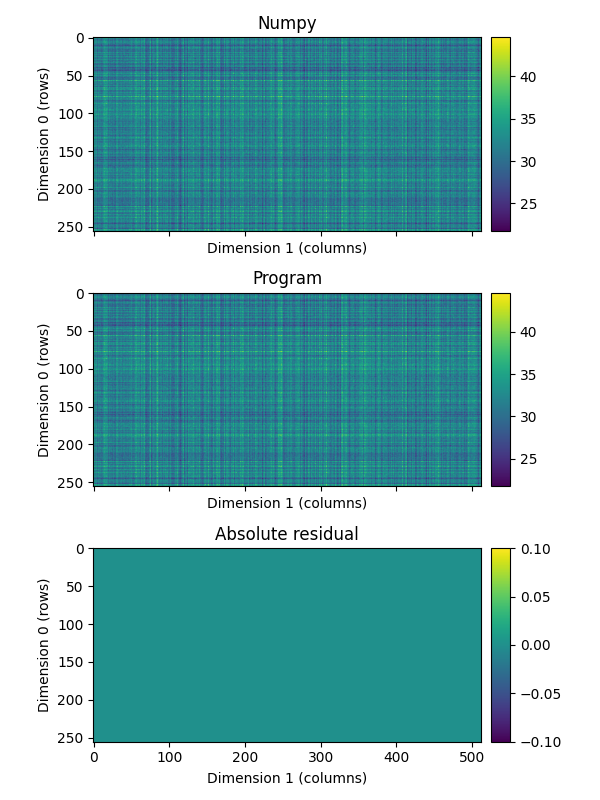

In [21]:
mat_mul.load_data()
mat_mul.check_data()

#### Managed memory.

Managed memory is another form of allocating memory that is accessible from **both the host and the compute device**. Managed memory leaves it to the runtime to `manage` or cache pages of memory on either the host or the compute device, and shuffle memory between host and device as required. Since pointers to managed memory are meaningful in both host and device memory spaces, just **one pointer** can be used for both modes of access.

In the program [mat_mult_managed_mem.cpp](mat_mult_managed_mem.cpp) we use managed memory to store matrices **A**, **B**, and **C**. Not every HIP device has support for managed memory, and we check for managed memory support with the following call to **h_check_managed** in <a href="../include/hip_helper.hpp">hip_helper.hpp</a>.

```C++
    // Check to make sure managed memory can be allocated
    h_check_managed_mem(dev_index);
```

In <a href="../include/hip_helper.hpp">hip_helper.hpp</a> the function **h_check_managed** has the following code:

```C++
/// Check to see if device supports managed memory, exit if it does not
void h_check_managed(int dev_index) {
    // Check to make sure managed memory access is supported
    int managed_capability = 0;
    H_ERRCHK(
        hipDeviceGetAttribute(
            &managed_capability,
            hipDeviceAttributeManagedMemory, 
            dev_index
        )
    );
    if (!managed_capability) {
        std::printf("Sorry, device %d cannot allocate managed memory\n", dev_index);
        exit(EXIT_FAILURE); 
    }    
}
```

Then we allocate managed memory using the call to **hipMallocManaged** as follows:

```C++
    // Allocate pinned memory for the host arrays
    float *A_m, *B_m, *C_m;
    H_ERRCHK(
        hipMallocManaged(
            (void**)&A_m, 
            nbytes_A, 
            hipMemAttachGlobal
        )
    );
    H_ERRCHK(
        hipMallocManaged(
            (void**)&B_m, 
            nbytes_B, 
            hipMemAttachHost
        )
    );
    H_ERRCHK(
        hipMallocManaged(
            (void**)&C_m, 
            nbytes_C
        )
    );
```

Two different flags are used here during a call to **hipMallocManaged**. The flag **hipMemAttachGlobal** means the memory can be accessed by any stream on any device. The flag **hipMemAttachHost** appears to mean that the memory is initially allocated on the host. No flag means **hipMemAttachGlobal**, which is the default. 

The function **hipMemAdvise** can provide the HIP runtime hints as to how managed memory (and only managed memory) will be used. This information can help optimise performance with managed memory.

After allocation memory we need no additional steps to use the memory from within a kernel. Deallocation of managed memory is performed with a call to **hipFree**.

```C++
    // Clean up managed memory on the host   
    H_ERRCHK(hipFree(A_m));
    H_ERRCHK(hipFree(B_m));
    H_ERRCHK(hipFree(C_m));
```

##### Testing the managed memory allocation

In [22]:
!build mat_mult_managed_mem.exe; run mat_mult_managed_mem.exe

[ 50%] Built target hip_helper
[100%] Built target mat_mult_managed_mem.exe
Install the project...
-- Install configuration: "RELEASE"
Device id: 0
	name:                                    AMD Radeon VII
	global memory size:                      17163 MB
	available registers per block:           65536 
	max threads per SM or CU:                2560 
	maximum shared memory size per block:    65 KB
	maximum shared memory size per SM or CU: 65 KB
	maximum pitch size for memory copies:    2147 MB
	max block size:                          (1024,1024,1024)
	max threads in a block:                  1024
	max Grid size:                           (2147483647,65536,65536)
Maximum error (infinity norm) is: 1.14441e-05


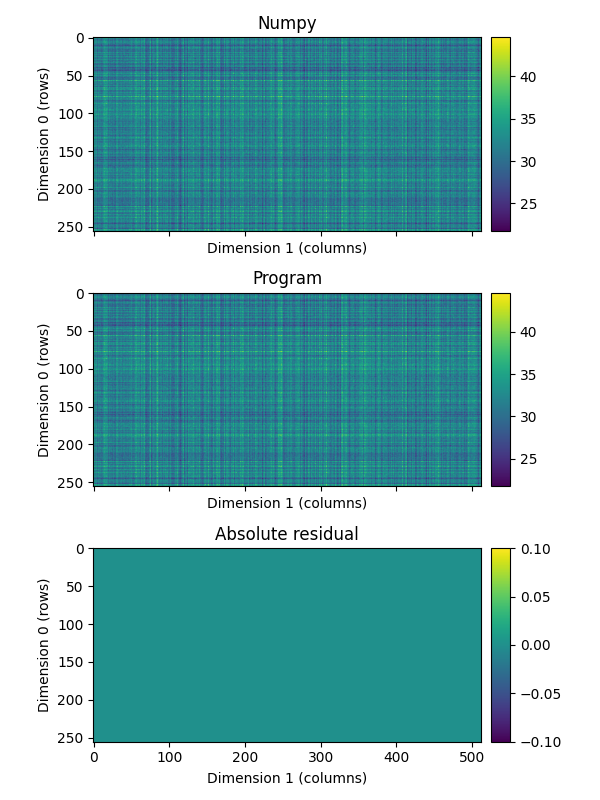

In [23]:
mat_mul.load_data()
mat_mul.check_data()

### Explicit memory transfers in HIP

Sometimes using pinned or managed memory is neither performant or available, and you need to resort to explicit memory movement techniques to copy memory between host and device. When copying memory in HIP you have the option of copying either **contiguous** or **rectangular** regions of allocated memory, and the option of using either regular (blocking) or asynchronous (non-blocking) transfers. By rectangular I mean that if the memory allocation is interpreted as **folded into a multidimensional array**, then a rectangular copy would copy a **rectangular region** of that array.

#### Contiguous memory copies

<figure style="margin-left:auto; margin-right:auto; width:80%;">
    <img style="vertical-align:middle" src="../images/contiguous_memory_copy.svg">
    <figcaption style= "text-align:lower; margin:1em; float:bottom; vertical-align:bottom;">Contiguous memory copy.</figcaption>
</figure>

If you only need to copy contiguous chunks of memory, then **hipMemcpy** is available to help with that. The usage and flags for **hipMemcpy** is covered in the matrix multiplication example from Lesson 3. The command **hipMemcpyAsync** is the asychronous complementary function to **hipMemcpy**, it takes as an extra argument the **stream** in  which you would like the work to take place, and will only **return immediately** if the host memory you are copying from/to is **pinned**, i.e it is allocated with **hipHostMalloc**.

#### Rectangular copies

Sometimes a contiguous copy is not sufficient, such as when you need to copy rectangular boundary areas of a multi-dimensional array.

<figure style="margin-left:auto; margin-right:auto; width:80%;">
    <img style="vertical-align:middle" src="../images/rectangular_memory_copy.svg">
    <figcaption style= "text-align:lower; margin:1em; float:bottom; vertical-align:bottom;">Rectangular memory copy.</figcaption>
</figure>

##### 2D copies with hipMemcpy2D

The functions **hipMemcpy2D** and **hipMemcpy2DAsync** can copy 2D rectangular regions if you specify the **length along a pencil** to copy, the pitch of each pencil, and the number of pencils to copy. However there isn't the ability to specify a starting location along a pencil. In the code [mat_mult_pitched_mem.cpp](mat_mult_pitched_mem.cpp) we use **hipMemcpy2D** to copy **A_h** to **A_d**.

```C++
    //// Step 5. 1. Upload matrices A_h and B_h from the host //// 
    //// to A_d and B_d on the device ////
    H_ERRCHK(
        hipMemcpy2D(
            // destination pointer
            A_d,
            // destination pitch
            pitch_A,
            // source pointer
            A_h,
            // source pitch
            N1_A*sizeof(float),
            // width is number of bytes along a pencil that is transferred
            N1_A*sizeof(float),
            // height is the number of pencils that are transferred
            N0_C,
            // copy flag
            hipMemcpyHostToDevice
        )
    );
```

The sibling function **hipMemcpy2DAsync** requires an additional parameter that is the stream to perform the copy in. If the host memory is **pinned** then this function will return immediately and the copy will take place in the stream you specify.

##### Multi-dimensional copies with hipMemcpy3D

If more than one plane is required, or you need to also specify the starting location along a pencil to begin a copy, then the functions **hipMemcpy3D** and **hipMemcpy3DAsync** can copy 1D, 2D and 3D rectangular regions in memory allocations while keeping track of things like memory pitch. 

The function **hipMemcpy3D** takes one argument of type **hipMemcpy3DParms**, however it is a complex structure to fill with the following fields:

| field | data type | explanation |
|:---|:---|:---|
| srcArray | hipArray_t | source array (we don't use this for this example, set to 0) |
| srcPos | hipPos | structure for the position in the source allocation, with **field**:(units) being {**x**:(byte position of copy), **y**:(starting pencil), **z**:(starting plane)} |
| srcPtr | hipPitchedPtr | Pitched pointer for the source allocation, **field**:(units) being {**ptr**:(void*), **pitch**:(bytes allocated for each pencil), **xsize**:(elements along a pencil that are valid), **ysize**:(number of pencils in a plane)} |
| dstArray | hipArray_t | destination array (we don't use this for this example,  set to 0) |
| dstPos | hipPos | structure for the position in the destination allocation, with **field**:(units) being {**x**:(byte position of copy), **y**:(starting pencil), **z**:(starting plane)} |
| dstPtr | hipPitchedPtr | Pitched pointer for the destination allocation, **field**:(units) being {**ptr**:(void*), **pitch**:(bytes allocated for each pencil), **xsize**:(elements along a pencil that are valid), **ysize**:(number of pencils in a plane)} |
| extent | hipExtent | Structure for how large the region to copy is, **field**:(units) being {**width**:(bytes along a pencil to copy), **height**:(number of pencils in a plane to copy), **depth**:(number of pencil planes to copy)} |
| kind | enum hipMemcpyKind | Type of copy, e.g **hipMemcpyDeviceToHost** |

In the code [mat_mult_pitched_mem.cpp](mat_mult_pitched_mem.cpp) is an example where we use **hipMemcpy3D** to copy from matrix **C_d** to **C_h**. First we create an object of type **hipMemcpy3DParms** to hold the parameters of the copy.

```C++
    // Create the object to hold 
    // the parameters of the 3D copy
    hipMemcpy3DParms copy_parms = {0};
```

Next, we need to make pitched pointers for the host and device allocations and fill the **srcPtr** and **dstPtr** fields of **copy_parms**. We can use the function **make_hipPitchedPtr** to do this. In order to make a pitched pointer we need the following information 

* A **pointer** to the memory allocation.
* The **pitch** (or length of each pencil in bytes).
* The requested pencil **width** (in elements).
* The number of pencils in a plane, or **height** (not the total number of pencils). 

We do this in code as follows:

```C++
    // Create pitched pointers 
    // For the host
    hipPitchedPtr C_h_ptr = make_hipPitchedPtr(
        C_h, // pointer 
        N1_C*sizeof(float), // pitch - actual pencil width (bytes) 
        N1_C, // requested pencil width (elements)
        N0_C // number of pencils in a plane (elements)
    );
    // For the device
    hipPitchedPtr C_d_ptr = make_hipPitchedPtr(
        C_d, // pointer
        N1_C*sizeof(float), // pitch - actual pencil width (bytes) 
        N1_C, // requested pencil width (elements)
        N0_C // number of pencils in a plane (elements)
    );
```

It is important to note that when constructing an object of type **hipPitchedPtr** that for the last parameter (the height) you must specify the number of pencils in a plane, and **not the total number of pencils**. I found this out the hard way when using **hipMemcpy3D**. The allocation of course could have three dimensions or more, and contain many planes, however when constructing a pitched pointer we need to specify the number of pencils in a plane (the height) as the **last argument** to **make_hipPitchedPtr**.

Next, we need the starting position for the memory copy in each allocation and fill the fields **srcPos** and **dstPos** of **copy_parms**. The function **make_hipPos** takes in the arguments:

* Position along a pencil (in bytes)
* Starting pencil index (elements)
* Starting pencil plane index (elements)

We deploy this function in [mat_mult_pitched_mem.cpp](mat_mult_pitched_mem.cpp) for the memory copy:

```C++
    // Postion within the host array
    hipPos C_h_pos = make_hipPos(
        0*sizeof(float), // byte position along a pencil (bytes)
        0, // starting pencil index (elements)
        0 // start pencil plane index (elements)
    );
    // Postion within the device array
    hipPos C_d_pos = make_hipPos(
        0*sizeof(float), // byte position along a pencil (bytes)
        0, // starting pencil index (elements)
        0 // starting pencil plane index (elements)
    );
```

Lastly, we need the **extent** or region of memory to copy. The function **make_hipExtent** takes the arguments:

* Width along a pencil to copy (in bytes)
* Number of pencils to copy in a pencil plane
* Number of pencil planes to copy

Now fill **copy_parms** using the data structures created above.

```C++
    // Fill the copy parameters
    copy_parms.srcPtr = C_d_ptr;
    copy_parms.srcPos = C_d_pos;
    
    copy_parms.dstPtr = C_h_ptr;
    copy_parms.dstPos = C_h_pos;
    
    copy_parms.extent = extent;
    copy_parms.kind = hipMemcpyDeviceToHost;
```

The memcpy flags we can use for **kind** are:

* hipMemcpyHostToHost
* hipMemcpyHostToDevice
* hipMemcpyDeviceToHost
* hipMemcpyDeviceToDevice
* hipMemcpyDefault

Finally, we perform the copy with **hipMemcpy3D** and **copy_parms** as its argument.

```C++
    H_ERRCHK(hipMemcpy3D(&copy_parms));
```

The **hipMemcpy3D** is a powerful copy function because it works with 1D, 2D, and 3D copies, but it is a **lot of work** to set up. As with contiguous memory copies, the rectangular copy function **hipMemcpy3D** has an asynchronous partner function **hipMemcpy3DAsync** that takes in a stream as an extra argument and the copy will be submitted to that stream. As with asynchronous contiguous copies, the host allocation **needs to be pinned** in order for a copy to be truly asynchronous and return immediately.

#### Fast copies between compute devices

When performing memory transfers between compute devices you can enable **peer-to-peer** memory transfers using the **hipDeviceEnablePeerAccess** function . Otherwise memory transfers that use the **hipMemcpyDeviceToDevice** flag will still work, but they will use a slower method of transfer with a host memory allocation as an intermediary.

#### Testing explicit memory transfers

We run the program that uses pitched memory and check the result.

In [24]:
!build mat_mult_pitched_mem.exe; run mat_mult_pitched_mem.exe

[ 50%] Built target hip_helper
[100%] Built target mat_mult_pitched_mem.exe
Install the project...
-- Install configuration: "RELEASE"
Device id: 0
	name:                                    AMD Radeon VII
	global memory size:                      17163 MB
	available registers per block:           65536 
	max threads per SM or CU:                2560 
	maximum shared memory size per block:    65 KB
	maximum shared memory size per SM or CU: 65 KB
	maximum pitch size for memory copies:    2147 MB
	max block size:                          (1024,1024,1024)
	max threads in a block:                  1024
	max Grid size:                           (2147483647,65536,65536)
Maximum error (infinity norm) is: 1.14441e-05


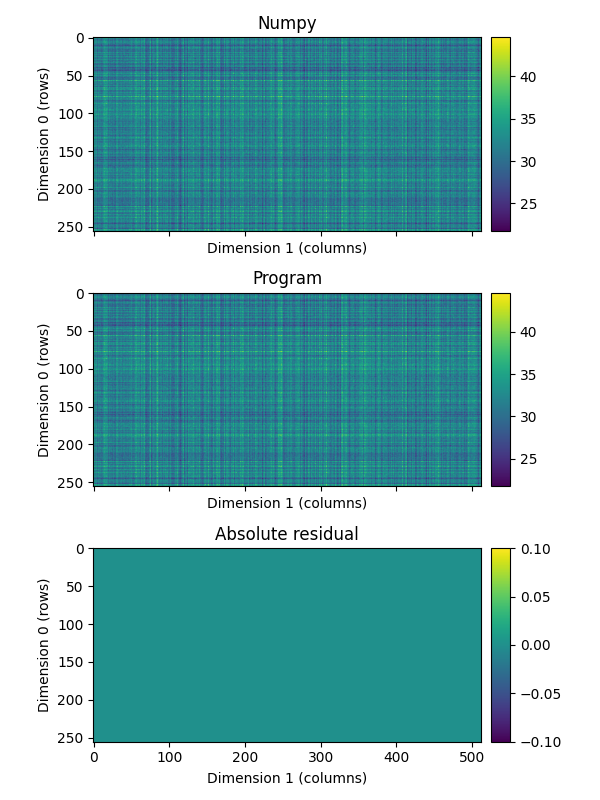

In [25]:
mat_mul.load_data()
mat_mul.check_data()

## Memory spaces visible to the kernel

Kernels have access to the following memory spaces on a compute device:

* Private memory (read-write memory stored registers)
* Shared memory (read-write memory stored on fast cache)
* Global memory (read-write main memory on device)
* Constant memory (read-only memory in fast cache)
* Texture memory (fast read-only access)
* L1 and L2 cache (automatically managed, but kernels can influence)

In this section we explore how to utilize each memory space from within a kernel.

### Private memory

Private memory (sometimes known as local memory in HIP/CUDA terminology) is the default storage space for variables created inside a running kernel. This memory is only available to the thread that allocates it. For example, in the **mat_mult_shared_A** kernel in [mat_mult_shared.cpp](mat_mult_shared.cpp) we declare a private variable **temp** to accumulate the dot product in matrix multiplication.

```C++
    // Scratch variable
    // Demonstrate copying from constant memory
    float_type temp=0.0*coeffs[0]; 
```

Private memory is usually allocated from the fastest register memory on the device, but the  amount of available register memory per thread is **fairly low** (on the order of 50-100 32-bit slots if every thread is active). If a kernel uses more register memory than there is available, then the number of active threads must be reduced, then if that is not sufficient, register memory can spill over into global memory at the cost of performance. 

### Global address space

Allocations of memory in the **global address space** are allocated by the host and accessed through pointers that are passed into a kernel launch. In the program [mat_mult_shared.cpp](mat_mult_shared.cpp) we pass in allocations of memory for arrays **A**, **B**, and **C** to the kernel **mat_mult_shared_A**.

```C++
// Matrix multiply kernel that uses shared memory for A
__global__ void mat_mult_shared_A (
                        float_type* A, 
                        float_type* B, 
                        float_type* C,
                        size_t N1_A, 
                        size_t N0_C,
                        size_t N1_C) { 
    
    ...
```

Due to the way compilation works, one cannot reinterpret memory passed in as another data type, as is possible with OpenCL. Therefore memory that is passed in at kernel launch must have the same data type as in the kernel.

### Constant memory

Constant memory is located in fast memory storage and is defined by the **\_\_constant\_\_** address qualifier. This memory is declared outside the kernel. In [mat_mult_shared.cpp](mat_mult_shared.cpp) we declare an array of coefficients called **coeffs**.

```C++
// Define some constant memory
__constant__ float coeffs[3] = {0};
```

#### Write access from the host

Within the main program we use the function **hipMemcpyToSymbol** to copy memory from the main program to the allocated constant memory. From this [source](https://rocm.docs.amd.com/projects/HIP/en/develop/user_guide/hip_porting_guide.html) the destination pointer for the copy needs to be encased in the macro **HIP_SYMBOL**.

```C++
    // Copy memory to the coefficients
    float temp_coeffs[NCOEFFS] = {1};
    H_ERRCHK(
        hipMemcpyToSymbol(
            HIP_SYMBOL(coeffs), 
            temp_coeffs, 
            NCOEFFS*sizeof(float)
        )
    );
```

Constant memory is available in every thread, including device functions that are called from kernels. In [mat_mult_shared.cpp](mat_mult_shared.cpp) we intialise a constant called **temp** through accessing the constant memory in **coeffs**.

```C++
    // Scratch variable
    // Demonstrate access of constant memory
    float_type temp=0.0*coeffs[0];
```

### Shared memory

Memory that is **shared** is available for reading and writing from **every thread** in the block, even if a block consists of more than one thread team. However since threads and thread teams in a block don't always finish work at the same time, there must be **block-level synchronisation** before threads can read what others have written.

Shared memory is often located in high bandwidth, low latency cache on the compute device and **might** provide a speed boost by virtue of being in close proximity (in terms of latency and bandwidth) to the hardware threads that execute a kernel. However HIP devices are adept at caching global memory to fast cache, so you **might not always** see a performance boost by using shared memory.

There are two ways to allocate shared memory for use in a kernel, both **static** and **dynamic** allocation. In the program [mat_mult_shared.cpp](mat_mult_shared.cpp) we demonstrate both ways of making shared memory available.

#### Static allocation of shared memory

Static allocations of shared memory happen within the body of the kernel function and must have the **\_\_shared\_\_** qualifer. In [mat_mult_shared.cpp](mat_mult_shared.cpp) we statically allocate an array of 10 floats.

```C++
    // Example allocation of static memory
    __shared__ float_type shared_temp[10];
```

Static allocations of shared memory are not limited to the outermost scope within the allocation, however all threads that **must** access the allocation also must encounter the allocation statement.

#### Dynamic reservation of shared memory

Shared memory for a block may also be dynamically reserved when the kernel is **launched**. The size of shared memory to allocate is an argument to **hipLaunchKernelGGL**. In [mat_mult_shared.cpp](mat_mult_shared.cpp) we specify an amount of shared memory to reserve in the variable **sharedMemBytes** and pass it to **hipLaunchKernelGGL**.

```C++
    // Amount of shared memory to use in the kernel
    size_t sharedMemBytes=block_size.y*N1_A*sizeof(float_type);
    
    // Launch the kernel using hipLaunchKernelGGL method
    // Use 0 when choosing the default (null) stream
    hipLaunchKernelGGL(mat_mult_shared_A, 
            grid_nblocks, 
            block_size, sharedMemBytes, 0, 
            A_d, B_d, C_d,
            N1_A,
            N0_C,
            N1_C
    );
```

Within the kernel we use the **extern \_\_shared\_\_** qualifiers to access the dynamically reserved memory. In the kernel **mat_mult_shared** we access the dynamically reserved memory through an array of type **char**.

```C++
    // Access the allocation of shared memory
    extern __shared__ char shared[];
```

This can only be done **once** within a kernel however. If you need multiple shared memory spaces you can use a static cast to interpret portions of that memory however you wish. Here we use a static cast to interpret the address of the allocation at index 0 as an allocation of floats.

```C++
    // Get a pointer to shared_A from shared
    float* shared_A = (float*)&shared[0];
```



#### Example, matrix multiplication with shared memory

There is an opportunity to employ shared memory within the matrix multiplication example. A block is of size **(L0, L1)** in the coordinate system of the matrices. Every thread along a row of the block needs access to the same row of matrix A, and every column in the block needs access to the same column of matrix B. If each thread in the block prefetches a section of a row of **A** into fast storage, then there is potential to save time on fetches from global memory.

Using the dynamic memory allocation method above, we allocate a shared memory space **shared_A** to store the rows of A that will be used by the block of threads. The shared memory allocation is of size (L0, N1_A).

<figure style="margin-left:auto; margin-right:auto; width:100%;">
    <img style="vertical-align:middle" src="../images/matrix_multiplication_shared_A.svg">
    <figcaption style= "text-align:lower; margin:1em; float:bottom; vertical-align:bottom;">Using shared memory in matrix multiplication.</figcaption>
</figure>

We divide the shared memory space into sections of elements along dimension 1 so that every thread in a block can be responsible for filling a portion of **shared_A**. There are **L1** blocks (along dimension 1) to copy for **shared_A**. The kernel code for filling the shared memory is below.

```C++
    // start and end positions for the copy
    size_t start, end;
    
    // Get the start and end lengths to fill array
    get_start_end(L1, N1_A, s1, &start, &end);
    
    // Fill shared_A
    if (i0<N0_C) {
        for (size_t n=start; n<end; n++) {
            shared_A[s0*N1_A+n]=A[i0*N1_A+n]; 
        }   
    }
```

We use a kernel function called **get_start_end** to get the start and end indices of a block along dimension 1 of shared memory. Then we use a loop to fill the **shared_A** from the allocation for matrix A on the device. 

##### Thread synchronisation

Threads in a block will often finish work before others, however in order to keep in sync (and avoid a data race) they need to be made to **wait** until all other threads have completed. A call to the inbuilt HIP kernel function **__syncthreads**  ensures that shared memory is consistent among block threads before proceeding.

```C++
    // mat_mult_shared.cpp source
    
    // Set a barrier to ensure that all threads 
    // sync to this point before moving on 
    __syncthreads();
```

> The absence of a barrier is often a source of bugs. Threads executed on GPU's operate in lock-step and in thread teams, so consistency between threads and shared memory is somewhat less of an issue (unless multiple thread teams are present in a block). On a CPU implementation of HIP the threads execute independently and a barrier is **vital** for consistency.

After the barrier, **shared_A** is populated and available for all threads. During the dot product step we draw from the shared memory allocation for accessing **A** instead of global memory. 

```C++
    // Scratch variable
    // Demonstrate access of constant memory
    float_type temp=0.0*coeffs[0]; 
    
    // Guard mechanism to make sure we do not go
    // outside the boundaries of matrix C
    if ((i0<N0_C) && (i1<N1_C)) {
        
        // Loop over columns of A and rows of B 
        for (size_t n=0; n<N1_A; n++) {
            
            // A is of size (N0_C, N1_A)
            // B is of size (N1_A, N1_C)
            // shared_B is of size (L1, N1_A)
            // C is of size (N0_C, N1_C)
            
            // Loop across row s0 of shared_A
            // and down column i1 of B
            temp+=shared_A[s0*N1_A+n]*B[n*N1_C+i1];
            
        } 
        
        // Number of rows in C is same as number of rows in A
        C[i0*N1_C+i1]=temp;
    }
```

The matrix multiplication code in [mat_mult_shared.cpp](mat_mult_shared.cpp) and the associated kernel **mat_mult_shared_A** are using the local memory implementation. Feel free to run the example to verify that it works!

##### **Running the application**

In [33]:
!build mat_mult_shared.exe; run mat_mult_shared.exe

[ 50%] Built target hip_helper
Scanning dependencies of target mat_mult_shared.exe
[100%] Built target mat_mult_shared.exe
Install the project...
-- Install configuration: "RELEASE"
-- Set runtime path of "/nethome/tpotter/Pelagos/Projects/HIP_Course/course_material/install/bin/mat_mult_shared.exe" to "/nethome/tpotter/Pelagos/Projects/HIP_Course/course_material/install/lib"
Device id: 0
	name:                                    AMD Radeon VII
	global memory size:                      17163 MB
	available registers per block:           65536 
	max threads per SM or CU:                2560 
	maximum shared memory size per block:    65 KB
	maximum shared memory size per SM or CU: 65 KB
	maximum pitch size for memory copies:    2147 MB
	max block size:                          (1024,1024,1024)
	max threads in a block:                  1024
	max Grid size:                           (2147483647,65536,65536)
Maximum error (infinity norm) is: 1.14441e-05


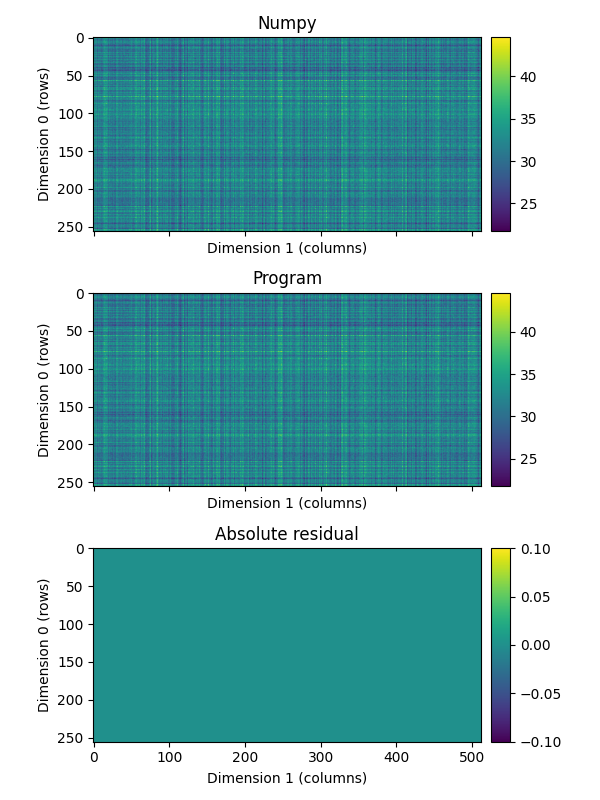

In [34]:
mat_mul.load_data()
mat_mul.check_data()

#### Limits on the size of shared memory requests

It is important that the size of a request for shared memory be kept low and within limits. Limits on the amount of shared memory available per block can be queried with the following code:

```C++
    // Report some information on a compute device
    hipDeviceProp_t prop;

    // Get the properties of the compute device
    H_ERRCHK(hipGetDeviceProperties(&prop, device_id));

    // Maximum shared memory size per block
    std::printf("\t%-40s %lu KB\n","maximum shared memory size per block:",prop.sharedMemPerBlock/(1000));

    // Maximum Shared memory size per Compute Unit/Multiprocessor
    std::printf("\t%-40s %lu KB\n","maximum shared memory size per SM or CU:", prop.maxSharedMemoryPerMultiProcessor/(1000));
```

If the amount of shared memory requested is too large, then the kernel will fail to launch or run correctly. In the code [mat_mult_shared_A_faulty.cpp](mat_mult_shared_A_faulty.cpp) is an example where we ask for too much memory at kernel launch. In this example we ask for 1000 times more shared memory than we need:

```C++
    // Amount of shared memory to use in the kernel
    size_t sharedMemBytes=1000*block_size.y*N1_A*sizeof(float_type);
```

When the kernel is launched, it results in an error with code **invalid argument**, that is picked up by the call to **hipGetLastError**.

```C+++
    // Check for errors in the kernel launch
    H_ERRCHK(hipGetLastError());
```

In [35]:
!build mat_mult_shared_faulty.exe; run mat_mult_shared_faulty.exe

[ 50%] Built target hip_helper
[100%] Built target mat_mult_shared_faulty.exe
Install the project...
-- Install configuration: "RELEASE"
Device id: 0
	name:                                    AMD Radeon VII
	global memory size:                      17163 MB
	available registers per block:           65536 
	max threads per SM or CU:                2560 
	maximum shared memory size per block:    65 KB
	maximum shared memory size per SM or CU: 65 KB
	maximum pitch size for memory copies:    2147 MB
	max block size:                          (1024,1024,1024)
	max threads in a block:                  1024
	max Grid size:                           (2147483647,65536,65536)
Error, HIP call failed at /nethome/tpotter/Pelagos/Projects/HIP_Course/course_material/L6_Memory_Management/mat_mult_shared_faulty.cpp:233, error string is: invalid argument


It is important to note that static allocations of shared memory *don't seem to be rigorously checked for validity* at kernel launch. You can try this by setting the variable **large** in the kernel **mat_mult_shared_A** in [mat_mult_shared_faulty.cpp](mat_mult_shared_faulty.cpp), therefore dynamic allocations are safer to use.

## Vectors in HIP

Like CUDA, HIP defines a number of vector types with **n** = 1,2,3, and 4 elements. Vectors can unlock performance within a HIP application because memory is loaded into caches using cache lines that are typically around 64-128 bytes (or 16-32 floats) wide and vectors can provide compiler hints to optimise that access. Furthermore, CPU's and some GPU's have SIMD units that can process vectors of floats using one instruction. Here are the vector types as used in both host and kernel code.

| Vector type |  Number of bits used, description |  
| :- | :- |
| char**n** |  **n** x 8 bits, signed two's complement integers  |
| uchar**n** |  **n** x 8 bits, unsigned integers |
| short**n** |  **n** x 16 bits, signed two's complement integers |
| ushort**n** |  **n** x 16 bits, unsigned integers |
| int**n** |  **n** x 32 bits, signed two's complement integers |
| uint**n** |  **n** x 32 bits, unsigned integers |
| long**n** |  **n** x 64 bits, signed two's complement integers |
| ulong**n** |  **n** x 64 bits, unsigned integers |
| longlong**n** |  **n** x 64 bits, signed two's complement integers 
| ulonglong**n** |  **n** x 64 bits, unsigned integers |
| float**n** |  **n** x 32 bits, floating point numbers |
| double**n** |  **n** x 64 bits, floating point numbers |

Access to the individual components of the vector **from both host and kernel** is through structure access to .x(yzw) depending on how many elements there are. In the program [vector_types.cpp](vector_types.cpp) is a program to work with the components of a vector.

```C++
    // One way to make a vector type
    float4 temp = (float4){0.0f, 1.0f, 2.0f, 3.0f};
    
    // Access to individual elements in a vector
    temp.x = 0.0f;
    temp.y = 1.0f;
    temp.z = 2.0f;
    temp.w = 3.0f;
    
    // Shortened quick form to make vector
    float4 temp2 = (float4){0.0f};
    
    // Another way to make a vector type 
    // using the make_<vector type> function
    float4 temp3 = make_float4(1.0f, 2.0f, 3.0f, 4.0f);
    
    std::printf("temp.w is %f\n", temp.w);
```

The program prints out the size of a number of signed vector types. The unsigned types are the same size as the signed types.

In [36]:
!build vector_types.exe; run vector_types.exe

[ 50%] Built target hip_helper
[100%] Built target vector_types.exe
Install the project...
-- Install configuration: "RELEASE"
Size of char1: 1
Size of short1: 2
Size of int1: 4
Size of long1: 8
Size of longlong1: 8
Size of float1: 4
Size of float2: 8
Size of float3: 12
Size of float4: 16
Size of double1: 8
temp.w is 3.000000


### Complex numbers in HIP

Complex numbers are not implemented in HIP, however you can store the real and imaginary components in a **float2** or **double2** vector type for example. One must then manually perform the complex number math operations on the individual components **x** and **y**.

### Example, using vectors for matrix multiplication

In the program [mat_mult_shared_vector.cpp](mat_mult_shared_vector.cpp) and in the kernel **mat_mult_shared_vector**  we extend the shared memory solution to work with **A** and **shared_A** as allocations of vectors of type **float4**. This means that loads and stores will happen 4 floats at a time, which might be advantageous for memory copies and utilising vector hardware in compute devices.

Here is the current shared memory solution for matrix multiplication.

<figure style="margin-left:auto; margin-right:auto; width:100%;">
    <img style="vertical-align:middle" src="../images/matrix_multiplication_shared_A.svg">
    <figcaption style= "text-align:lower; margin:1em; float:bottom; vertical-align:bottom;">Using shared memory in matrix multiplication.</figcaption>
</figure>

If we interpret **A** and **shared_A** as allocations of 4-element floats, then we need to make sure the axis **N1_A** is a multiple of 4 elements. Therefore we must potentially enlarge the allocation along dimension 1 so that an integer number of vectors fit along that dimension. We specify a length **N1_A_v** which is the minimum number of vectors that will fit all of the elements along a row of **A**.

```C++
    // Get the vector length
    size_t vector_len = sizeof(float_vec_type)/sizeof(float_type);

    // Get the nearest acceptable vector length
    size_t N1_A_v = N1_A/vector_len;
    if (N1_A%vector_len) N1_A_v++;
```

Then we make sure **A_d** is allocated as memory of type **float_vec_type**, using the enlarged size. 

```C++
    size_t nbytes_A_v = N0_C*N1_A_v*sizeof(float_vec_type);
    float_vec_type *A_d; 
    float_type *B_d, *C_d;
    
    // Allocate memory for A_d, B_d and C_d normally
    H_ERRCHK(hipMalloc((void**)&A_d, nbytes_A_v));
```

We could have also used **pitched memory** for this allocation as it lends naturally to the idea of a requested size (along the contiguous dimension, or dimension 1) and an actual size. Next, we fill **A_d** with zeros so that any leftover space will contain zeros.

```C++
    // Fill A_d with zeros
    H_ERRCHK(
        hipMemset(
            A_d, // the pointer to set
            0, // the value to fill
            nbytes_A_v // number of bytes to fill
        )
    );
```

Then we copy **A_h** to **A_d** using the function **hipMemcpy2D**.

```C++
    // Memcpy2D method
    H_ERRCHK(
        hipMemcpy2D(
            (void*)A_d, // destination pointer
            N1_A_v*sizeof(float_vec_type), // destination pitch
            (void*)A_h, // source pointer
            N1_A*sizeof(float_type), // source pitch
            N1_A*sizeof(float_type), // width of pencils to copy
            N0_C, // number of pencils to copy
            hipMemcpyHostToDevice // type of memory transfer
        )
    );
```

Within the kernel **mat_mult_shared_vector** we bring in **A** as an allocation of **float_vec_type**, which is type defined as **float4**. Then we get the pointer to shared memory, also as an allocation of type **float_vec_type**.

```C++
// Matrix multiply kernel that uses shared memory for A
__global__ void mat_mult_shared_A_vector (
                        float_vec_type* A, 
                        float_type* B, 
                        float_type* C,
                        size_t vector_len,
                        size_t N1_A_v,
                        size_t N0_C,
                        size_t N1_C) {  

    // Access the allocation of shared memory
    extern __shared__ char shared[];
    
    // Get a pointer to shared_A from shared
    float_vec_type* shared_A = (float_vec_type*)&shared[0];    
```

During the fill of **shared_A** we walk across row **i0** of **A** and fill sections of shared memory. Then we synchronise threads to make sure that all threads have finished copying to **shared_A**.

```C++
    // Get the start and end lengths to fill array
    get_start_end(L1, N1_A_v, s1, &start, &end);
    
    // Fill shared_A
    if (i0<N0_C) {
        for (size_t n=start; n<end; n++) {
            shared_A[s0*N1_A_v+n]=A[i0*N1_A_v+n]; 
        }   
    }
    
    // Set a barrier to ensure that all threads 
    // sync to this point before moving on 
    __syncthreads();
```

Now that the fill of **shared_A** is complete we loop over **N1_A_v** and compute the dot product 4 elements at a time, keeping in mind that each iteration of the loop is now over **vectors** instead of array elements. Since **B** is not transposed or vectorised, we carefully fill components of the vector **scratch** with elements from **B** prior to computing the dot product. It turns out that HIP programs running with a CUDA backend do not support using math operations on vectors. Therefore, when we use a CUDA backend we have to resort to doing vector operations on an element by element basis. The macro `__HIP_PLATFORM_NVIDIA__` is available when HIP code is compiled for an NVIDIA backend.

```C++
    // Scratch variables
    // Demonstrate access of constant memory
    float_vec_type temp = (float_vec_type){0.0f}; 
    float_vec_type scratch = (float_vec_type){0.0f};
    
    // Guard mechanism to make sure we do not go
    // outside the boundaries of matrix C
    if ((i0<N0_C) && (i1<N1_C)) {
        
        // Loop over columns of A and rows of B 
        for (size_t n=0; n<N1_A_v; n++) {
            
            // A is of size (N0_C, N1_A_v)
            // B is of size (N1_A, N1_C)
            // shared_A is of size (L0, N1_A_v)
            // C is of size (N0_C, N1_C)
             
            float_type* Bn_i1=&B[n*vector_len*N1_C+i1];
            
            // Fill components of scratch
            scratch.x = Bn_i1[0*N1_C];
            scratch.y = Bn_i1[1*N1_C];
            scratch.z = Bn_i1[2*N1_C];
            scratch.w = Bn_i1[3*N1_C];
            
            // Perform the dot product using shared memory
#ifdef __HIP_PLATFORM_NVIDIA__
            temp.x += shared_A[n].x*scratch.x;
            temp.y += shared_A[n].y*scratch.y;
            temp.z += shared_A[n].z*scratch.z;
            temp.w += shared_A[n].w*scratch.w;
#else
            temp+=shared_A[n]*scratch;
#endif
        } 
```

At the end of the dot product we stack over components of the vector to get the final result which goes into **C** at coordinates **i0** and **i1**.


```C++
        // Number of rows in C is same as number of rows in A
        C[i0*N1_C+i1] = temp.x+temp.y+temp.z+temp.w;
    }
```

#### Run the vectorised application and check results

In [37]:
!build mat_mult_shared_vector.exe; run mat_mult_shared_vector.exe

[ 50%] Built target hip_helper
[100%] Built target mat_mult_shared_vector.exe
Install the project...
-- Install configuration: "RELEASE"
Device id: 0
	name:                                    AMD Radeon VII
	global memory size:                      17163 MB
	available registers per block:           65536 
	max threads per SM or CU:                2560 
	maximum shared memory size per block:    65 KB
	maximum shared memory size per SM or CU: 65 KB
	maximum pitch size for memory copies:    2147 MB
	max block size:                          (1024,1024,1024)
	max threads in a block:                  1024
	max Grid size:                           (2147483647,65536,65536)
Maximum error (infinity norm) is: 2.67029e-05


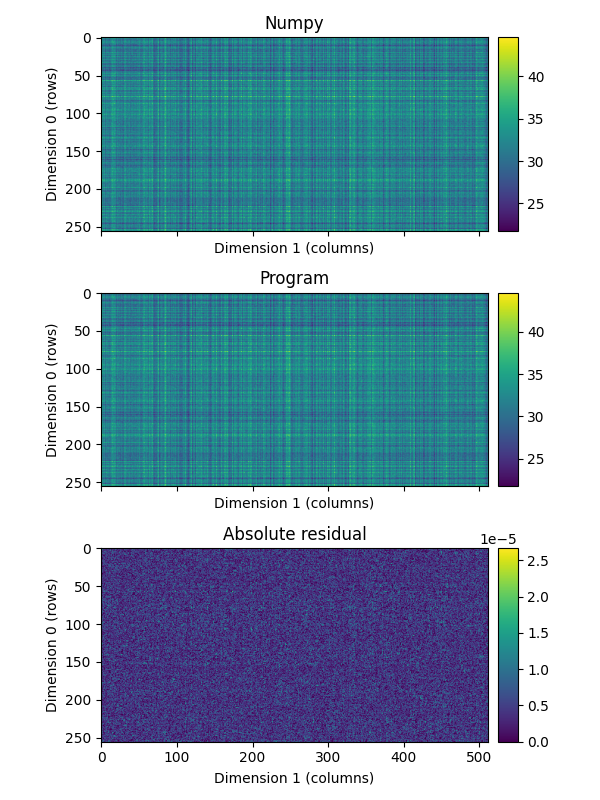

In [38]:
mat_mul.load_data()
mat_mul.check_data()

### Atomics in HIP

At the time of writing, support for atomic functions in HIP do not appear to be well documented. In CUDA there is support for functions like **atomicAdd** that provide atomic operations with device level synchronisation, meaning that the operation is atomic for all threads executed on the device. The functions **atomicAdd_system** can provide system level synchronisation (i.e host can atomically increment too),  and **atomicAdd_block** can provide perform an atomic add that is synchronised over all threads in a block.

In the program [atomics.cpp](atomics.cpp) we allocate memory for a single integer in global memory and use **atomicAdd** within a kernel to increment it from 65536 threads over a grid of size (256, 256). The kernel code is below:

```C++
// Kernel to test atomics
__global__ void atomic_test (int *counter) {
    
    // Increment T atomically with device-level synchronisation
    atomicAdd(counter, 1);
}
```

#### Run the program

In [39]:
!build atomics.exe; run atomics.exe

[ 66%] Built target hip_helper
[100%] Built target atomics.exe
Install the project...
-- Install configuration: "RELEASE"
Device id: 0
	name:                                    AMD Radeon VII
	global memory size:                      17163 MB
	available registers per block:           65536 
	max threads per SM or CU:                2560 
	maximum shared memory size per block:    65 KB
	maximum shared memory size per SM or CU: 65 KB
	maximum pitch size for memory copies:    2147 MB
	max block size:                          (1024,1024,1024)
	max threads in a block:                  1024
	max Grid size:                           (2147483647,65536,65536)
Counter has been incremented 65536 out of 65536 times


#### Notes on using atomics with fine-grained memory access

From [this site](https://www.olcf.ornl.gov/wp-content/uploads/crusher_tips_lessons.pdf) the atomics described above use a slow software-defined method of synchronisation to ensure atomicity. There is a faster version of hardware atomics that can be enabled with the hipcc compiler flag `-munsafe-fp-atomics`. However it is vital to use hardware atomics only when you are **sure** the global memory is using **coarse-grained memory**. If the global memory allocation i.e `counter` is from a fine-grained memory allocation (which allows for simultaneous access from the host) and hardware atomics are in use, then it can **silently fail** and produce incorrect results. Fine grained memory access occurs when pinned memory is allocated with the `hipHostMallocCoherent` flag (the default), or when managed memory is allocated without a followup call to `hipMemAdvise` with the flag `hipMemAdviseSetCoarseGrain`. See this [site](https://docs.olcf.ornl.gov/systems/crusher_quick_start_guide.html) for more information.

<address>
Written by Dr. Toby Potter of <a href="https://www.pelagos-consulting.com">Pelagos Consulting and Education</a> for the <a href="https://pawsey.org.au">Pawsey Supercomputing Research Centre</a>. All trademarks mentioned are the property of their respective owners.
</address>